# Driving During Quarantine:

## Full Analysis and Additional Graphs

### Authors: Shirley Wang, Eva Huang

----

Covid-19 is an infectious disease and has caused a global pandemic.  In an attempt to combat and prevent its spread, Prime Minister Trudeau has advocated for social distancing and self isolation. Hence, people are now incentivized to stay home as much as possible and limit contact with others to stop the spread of the virus.  We have decided to investigate how effective the call for social distancing has been in Toronto by viewing traffic data, where we investigated if there was a significant decrease in the amount of people driving in residential areas of Toronto.

## Data Gathering and Cleaning

The data is mainly gathered from the Open Toronto Data Catalogue, from the School Safety Zone Watch Your Speed Program’s [Detailed Speed Counts](https://open.toronto.ca/dataset/school-safety-zone-watch-your-speed-program-detailed-speed-counts/). In 2020, there are 444 locations scattered across Toronto, where a speed display sign was installed on a pole as part of the program, displaying the speed of oncoming vehicles and flashing lights if they violated the speed limit.  The dataset contains a count of vehicles it observed each hour for a range of speeds.

The Detailed Speed Counts is too large for Github, so it is sourced from the CKAN API.  The corresponding Locations dataset and the Toronto map data are downloaded.

In [1]:
import ast
from datetime import datetime
from io import BytesIO
import os
import requests
from urllib.request import urlopen
from zipfile import ZipFile

import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from shapely.geometry import asShape
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# getting metadata of school counts dataset
# data is sourced through the ckan api since it's too large to fit in github
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "d7522ce7-68b1-4f93-991a-0eb2f9ec7de5"}
package = requests.get(url, params = params).json()

# data readme
readme = package['result']['resources'][0]

# 2020 data
metadata2020 = package['result']['resources'][1]

In [3]:
# takes around 2 minutes
# datafiles in zipfile
datafiles = ['wys_stationary_detailed_202001.csv', 'wys_stationary_detailed_202002.csv', 
             'wys_stationary_detailed_202003.csv', 'wys_stationary_detailed_202004.csv']

school2020data = pd.DataFrame()

# opens zip, dumps contents of files into raw.csv, and then reads it in
resp = urlopen(metadata2020['url'])
with ZipFile(BytesIO(resp.read())) as myzip:
    for file in datafiles:
        with open('raw.csv', 'wb') as f:
            f.write(myzip.read(file))
            data = pd.read_csv('raw.csv')
            school2020data = pd.concat([school2020data, data])
            
school2020data = school2020data.reset_index(drop=True)

In [4]:
# takes around 30 seconds to run

def get_average(x):
    stripped = x[1:-1]
    nums = stripped.split(',')
    if nums[0] == '':
        return int(nums[1])
    elif nums[1] == '':
        return int(nums[0])
    else:
        bottom = int(nums[0])
        top = int(nums[1])

        return (bottom + top) / 2

# get a numeric speed for each speed bin
school2020data['average_speed'] = school2020data['speed_bin'].map(lambda speedrange: get_average(speedrange))

# encode timestamps in datetime format
school2020data['datetime'] = pd.to_datetime(school2020data['datetime_bin'])
school2020data['date'] = school2020data['datetime'].dt.date

In [5]:
# cut not used colums
school2020data = school2020data[['sign_id', 'datetime', 'date', 'volume', 'average_speed', 'speed_bin']]

# remove outlier sign 412
outlier = school2020data[school2020data['sign_id'] == 412]
school2020data = school2020data[school2020data['sign_id'] != 412]

In [6]:
# locations of signs data
# from https://open.toronto.ca/dataset/school-safety-zone-watch-your-speed-program-locations/
locations = pd.read_csv('data/Stationary Sign locations.csv')
locations = locations[['sign_id', 'schedule', 'min_speed', 'speed_limit', 'ward_no', 'geometry']]

In [7]:
# merge the dataframes
# NOTE: this can fail if there's not enough memory
# gotta do this before making the extra colums

schooldata = pd.merge(school2020data, locations, how='inner', on='sign_id')

In [8]:
# encoding important time periods
march12 = datetime(2020, 3, 12)
march25 = datetime(2020, 3, 25)

# schools close, social distancing starts
schooldata['quarantine'] = schooldata['date'] > march25.date()

# social distancing but essential businesses haven't closed yet
# this needs to be on one line or else I'll get a syntax error sorry
schooldata['hoardingseason'] = (schooldata['date'] >= march12.date()) & (schooldata['date'] <= march25.date())

In [9]:
# encoding dates as numbers
schooldata['date_numeric'] = schooldata['date'].map(lambda x: (x - datetime(2020, 1, 1).date()).days)
schooldata['hour_numeric'] = schooldata['datetime'].dt.hour
schooldata['datetime_numeric'] = schooldata['date_numeric'] * 24 + schooldata['hour_numeric']

In [10]:
# summing volumes across all speed bins to get the total volume each hour for each location
totalvolumedata = pd.DataFrame(school2020data.groupby(['sign_id', 'datetime'])['volume'].sum()).reset_index()

In [11]:
# for reference, a pretty wide spread of locations across Toronto
ward_counts = pd.DataFrame(schooldata.groupby('ward_no')['sign_id'].nunique())
ward_counts.rename(columns={'sign_id': 'Locations Per Ward'})

Locations Per Ward
ward_no                    
1                        18
2                        29
3                        21
4                        22
5                        18
6                        18
7                        21
8                         7
9                        15
10                        4
11                        5
12                        8
13                       10
14                       38
15                       16
16                       11
17                       20
18                       21
19                       28
20                       24
21                        8
22                       25
23                       16
24                       15
25                       12

In [12]:
# number of locations
len(totalvolumedata['sign_id'].unique())

444

In [13]:
# more information about each ward's socioeconomic status
# was not used, did not have enough time to properly analyze the socioeconomic status
# of each ward on how it handled quarantine
morestuff = pd.read_csv('data/wardsocioeconomic.csv')

In [14]:
# average volume of traffic for a rural area in an hour
averagevolume = pd.DataFrame(totalvolumedata.groupby('datetime')['volume'].mean()).reset_index()

fig = px.line(averagevolume, x='datetime', y='volume')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

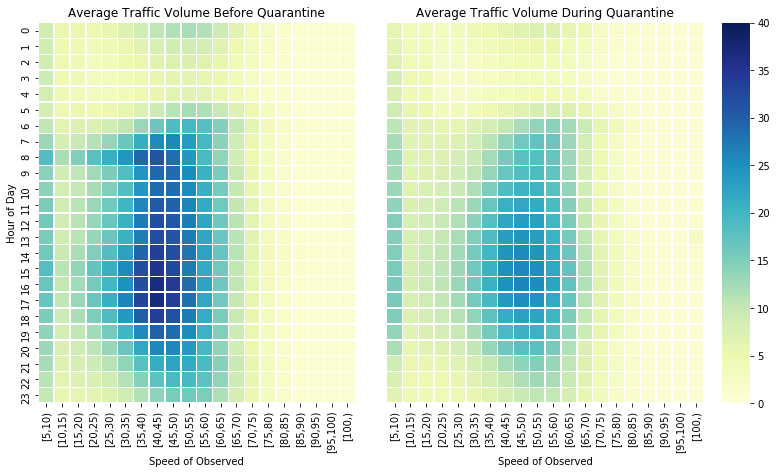

In [15]:
# heatmap of before and during quarantine

# speed bins
# they're strings so sorting doesn't reorder perfectly
speedbins = list(schooldata['speed_bin'].unique())
speedbins.sort()
speedbins = [speedbins[9]] + [speedbins[0]] + speedbins[2:9] + speedbins[10:] + [speedbins[1]] 

# before quarantine average volume by speed and hour of day

fig, axs = plt.subplots(1, 3, figsize=(13, 7), gridspec_kw={'width_ratios': [12, 12, 1], 'wspace': 0.02})

beforequarantine = pd.DataFrame(schooldata[~schooldata['quarantine']]
                        .groupby(['hour_numeric', 'average_speed'])['volume'].mean()).reset_index()

sns.heatmap(beforequarantine.pivot(index='hour_numeric', columns='average_speed', values='volume'),
            cmap="YlGnBu", ax=axs[0], vmax=40, vmin=0, xticklabels=speedbins, square=True,
            cbar=False, linewidth=0.5)

axs[0].set_xlabel("Speed of Observed")
axs[0].set_ylabel("Hour of Day")
axs[0].set_title("Average Traffic Volume Before Quarantine")


# during quarantine after nonessential businesses close

duringquarantine = pd.DataFrame(schooldata[(schooldata['quarantine']) & (~schooldata['hoardingseason'])]
                                .groupby(['hour_numeric', 'average_speed'])['volume'].mean()).reset_index()

sns.heatmap(duringquarantine.pivot(index='hour_numeric', columns='average_speed', values='volume'), 
            cmap="YlGnBu", ax=axs[1], vmax=40, vmin=0, xticklabels=speedbins, square=True, 
            cbar_ax=axs[2], linewidth=0.5)

axs[1].set_xlabel("Speed of Observed")
axs[1].set_title("Average Traffic Volume During Quarantine")
axs[1].get_yaxis().set_visible(False)

plt.savefig('heatmap.png')
plt.show()

## Linear Mixed Model

Notable factors for traffic volume:
- hour of day: Especially back when schools were open (periodic: 24)
- average speed:  Most change in volume happens in the 30-60km/h bins
- day of week:  There seems to be less traffic on weekends than weekdays when schools were open
- during quarantine: people are supposed to stay home and social distance during this time (after March 12)
- hoarding season: people were told to social distance but essential services weren't commanded to stay closed yet so lots of people were prone to panic buying resources (March 12 to March 25)
- ward_no: wards have some differences in socioeconomic status

Random effect: sign_id.  Sign_id is the unique identifier for each area where the sign radar is installed, and so the little differences between each area should be accounted for.  It appears to be a random intercept.

We have decided to aggregate the volume across all speeds to get total volume each hour to simplify the analysis.  The hourly volume of an area has a cyclic structure, depending on time of day and also day of week.  As a result, we have decided to handle this through seasonal decomposition and focus on the decomposed trend data, to properly understand how quarantine affected traffic volume.

We have decided to fit a linear mixed model on the seasonally decomposed trend data from all the locations, with factors quarantine, hoardingseason, and datetime, and sign_id as the random effect to account for the volume differences between different locations.

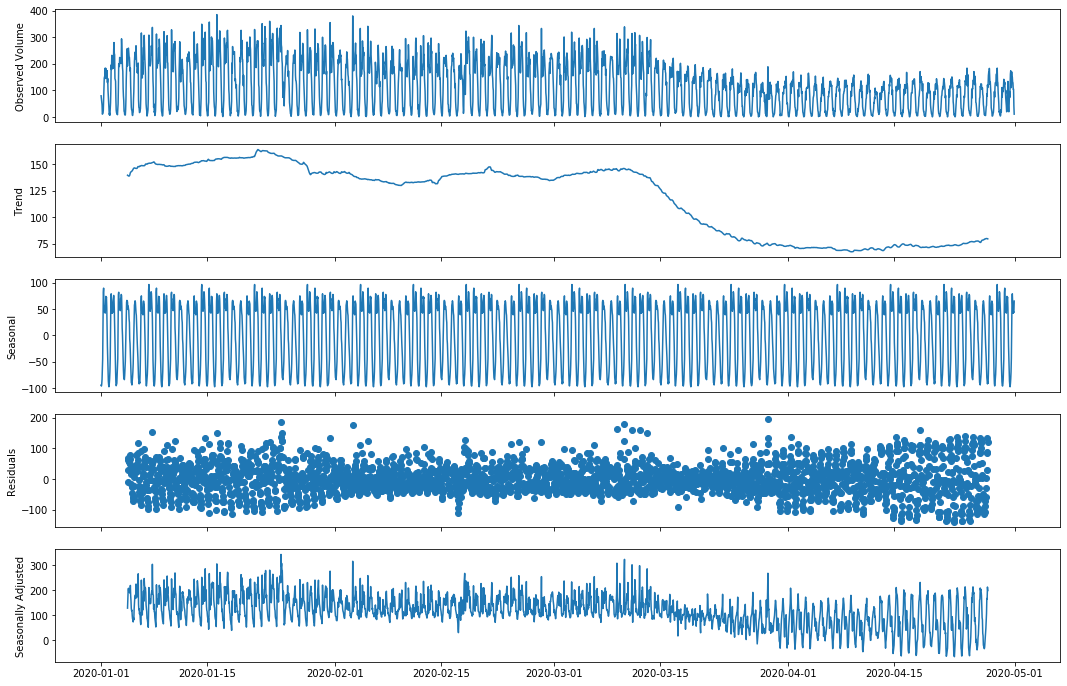

In [16]:
# example of seasonal decomposition

heredata = totalvolumedata[totalvolumedata['sign_id'] == 3]

datetimeindex = heredata['datetime']

result = seasonal_decompose(heredata['volume'], 
                            model='additive', period=168)

fig, axs = plt.subplots(5, 1, figsize=(18, 12), sharex=True)
axs[0].plot(datetimeindex, result.observed)
axs[0].set_ylabel("Observed Volume")
axs[1].plot(datetimeindex, result.trend)
axs[1].set_ylabel("Trend")

axs[2].plot(datetimeindex, result.seasonal)
axs[2].set_ylabel("Seasonal")

axs[3].scatter(datetimeindex, result.resid)
axs[3].set_ylabel("Residuals")

axs[4].plot(datetimeindex, result.trend + result.resid)
axs[4].set_ylabel("Seasonally Adjusted")
plt.show()

In [17]:
# extract trend for each area
areas = totalvolumedata['sign_id'].unique()
totalvolumedata['trend_volume'] = np.nan

for x in areas:
    curr_data = totalvolumedata[totalvolumedata['sign_id'] == x]
    
    # not enough observations from the location, exclude
    if len(curr_data) <= 336: 
        continue
    
    # period = 168: hours in a week to capture both hours of a day and days of a week seasonality
    result = seasonal_decompose(curr_data['volume'], model='additive', period=168)
    
    totalvolumedata.loc[totalvolumedata['sign_id'] == x, 'trend_volume'] = result.trend

In [18]:
withwards = pd.merge(totalvolumedata, locations, how='inner', on='sign_id')

# schools close, social distancing starts
withwards['quarantine'] = withwards['datetime'] >= march25

# social distancing but essential businesses haven't closed yet
# this needs to be on one line or else I'll get a syntax error sorry
withwards['hoardingseason'] = (withwards['datetime'] >= march12) & (withwards['datetime'] < march25)

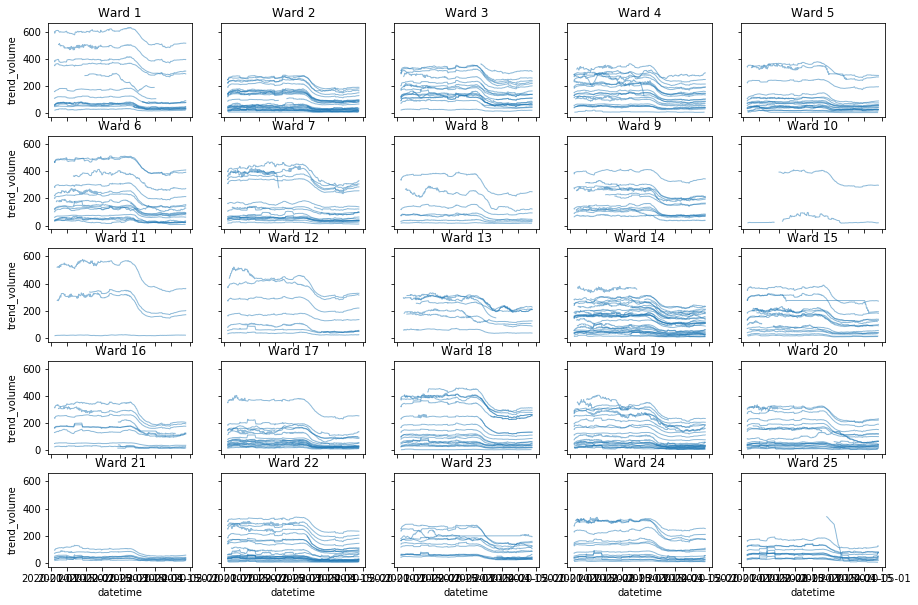

In [19]:
fig, axs = plt.subplots(5, 5, figsize=(15, 10), sharex=True, sharey=True)
for i in range(25):

    sns.lineplot(x="datetime", y="trend_volume", units="sign_id", 
                 data=withwards[withwards['ward_no'] == i + 1], 
                 estimator=None, lw=1, alpha=0.5, ax=axs[i // 5, i % 5])
    axs[i // 5, i % 5].set_title("Ward " + str(i + 1))

plt.show()

In [20]:
# data for building the model
modeldata = withwards.dropna().reset_index()

# specifically count from march 12 so the regression variable for hoarding season isn't extremely large
modeldata['date_numeric'] = modeldata['datetime'].map(lambda x: (x - march12).days)

modeldata['hour_numeric'] = modeldata['datetime'].dt.hour

modeldata['datetime_numeric'] = modeldata['date_numeric'] * 24 + modeldata['hour_numeric']

modeldata = modeldata[['trend_volume', 'sign_id', 'quarantine', 
                       'hoardingseason', 'datetime', 'datetime_numeric', 'ward_no']]

In [21]:
md = smf.mixedlm("trend_volume ~ quarantine + hoardingseason * datetime_numeric + datetime_numeric : quarantine", 
                 modeldata, groups=modeldata['sign_id'])

mdf = md.fit()

print(mdf.summary())

                          Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           trend_volume 
No. Observations:           965515            Method:                       REML         
No. Groups:                 419               Scale:                        324.7312     
Min. group size:            184               Log-Likelihood:               -4164147.0194
Max. group size:            2736              Converged:                    Yes          
Mean group size:            2304.3                                                       
-----------------------------------------------------------------------------------------
                                          Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------------------------------
Intercept                                 149.154    4.971   30.002 0.000 139.410 158.898
quarantine[T.True]                  

In [22]:
predictiondata = modeldata[['datetime_numeric', 'datetime', 'hoardingseason', 'quarantine']].drop_duplicates().reset_index()
predictiondata['ModelFit'] = mdf.predict(predictiondata)

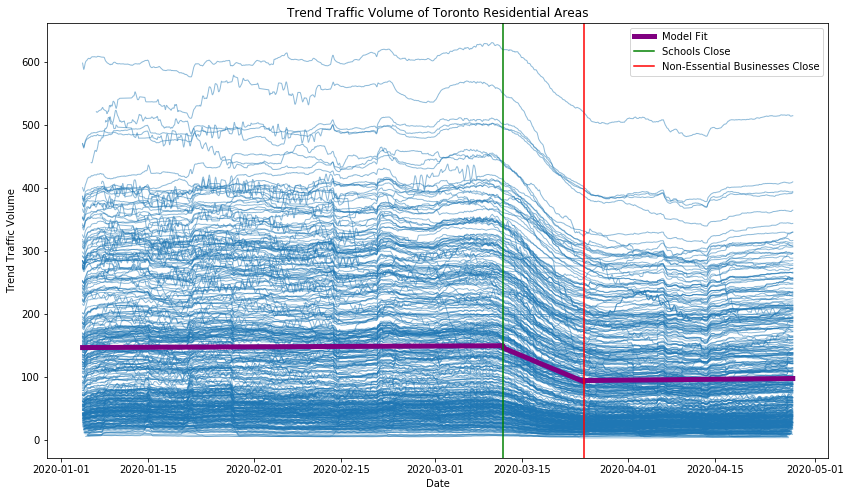

In [23]:
fig, axs = plt.subplots(figsize=(14, 8))
sns.lineplot(x="datetime", y="trend_volume", units="sign_id", data=withwards, 
             estimator=None, lw=1, alpha=0.5, ax=axs)

sns.lineplot(x="datetime", y="ModelFit", data=predictiondata, estimator=None, 
             lw=5, c='purple', ax=axs, label='Model Fit')

axs.set_xlabel("Date")
axs.set_ylabel("Trend Traffic Volume")
axs.set_title("Trend Traffic Volume of Toronto Residential Areas")

plt.axvline(x=march12, c='green', label='Schools Close')
plt.axvline(x=march25, c='red', label='Non-Essential Businesses Close')
plt.legend(loc=1)

plt.savefig("modelfit.png")
plt.show()

### Model Diagnostics

The residiuals are relatively normal, although the magnitude of some of the residuals may be a bit concerning.  The random effects do not appear to be normal, however, and appear more right skewed, which is an area of concern.

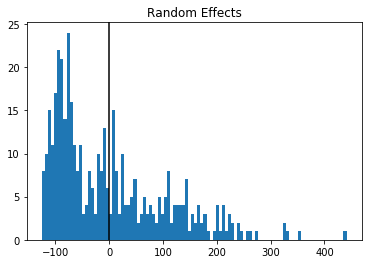

In [24]:
plt.hist([x['Group'] for x in list(mdf.random_effects.values())], bins=100)
plt.axvline(x=0, c='black')
plt.title("Random Effects")
plt.show()

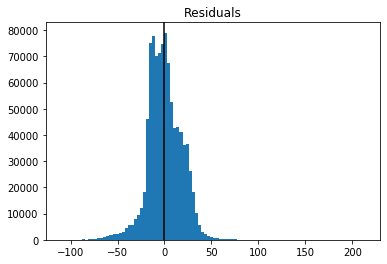

In [25]:
plt.hist(mdf.resid, bins=100)
plt.axvline(x=0, c='black')
plt.title("Residuals")
plt.show()

## Toronto Heatmap

In [26]:
toronto = gp.read_file('data/toronto/City Wards Data.shp')

columns = pd.read_csv('data/toronto/City Wards Data_fields.csv')

toronto = toronto.rename(columns=columns.set_index('field')['name'].to_dict())

toronto = toronto[['AREA_SHORT_CODE', 'AREA_NAME', 'LONGITUDE', 'LATITUDE', 'OBJECTID',
                   'Shape__Area', 'Shape__Length', 'geometry']]

#### Locations on Toronto

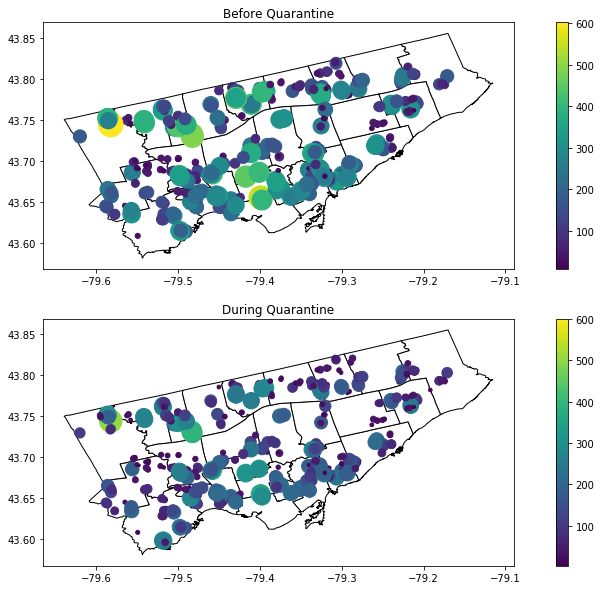

In [27]:
# before quarantine

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

axs[0].set_aspect('equal')
axs[1].set_aspect('equal')

locationaverages1 = modeldata[(~modeldata['quarantine']) & (~modeldata['hoardingseason'])].groupby('sign_id')['trend_volume'].mean()

locationaverages1 = pd.merge(locationaverages1.reset_index(), locations, how='inner', on='sign_id')

locationaverages1['geometry'] = locationaverages1['geometry'].map(lambda x: asShape(ast.literal_eval(x)))

gdf = gp.GeoDataFrame(locationaverages1, geometry='geometry')

toronto.plot(ax=axs[0], color='white', edgecolor='black')
gdf.plot(column='trend_volume', ax=axs[0], marker='o', markersize='trend_volume', legend=True)
axs[0].set_title("Before Quarantine")

# during quarantine

locationaverages2 = modeldata[modeldata['quarantine']].groupby('sign_id')['trend_volume'].mean()

locationaverages2 = pd.merge(locationaverages2.reset_index(), locations, how='inner', on='sign_id')

locationaverages2['geometry'] = locationaverages2['geometry'].map(lambda x: asShape(ast.literal_eval(x)))

gdf = gp.GeoDataFrame(locationaverages2, geometry='geometry')

toronto.plot(ax=axs[1], color='white', edgecolor='black')
gdf.plot(column='trend_volume', ax=axs[1], marker='o', markersize='trend_volume', legend=True, vmax=600)
axs[1].set_title("During Quarantine")

plt.show()

In [28]:
changes = pd.merge(locationaverages1[['sign_id', 'trend_volume', 'geometry', 'ward_no']], 
                   locationaverages2[['sign_id', 'trend_volume']], how='inner', on='sign_id')

changes['decrease_in_volume'] = changes['trend_volume_x'] - changes['trend_volume_y']

changes = changes[changes['decrease_in_volume'] > 0]

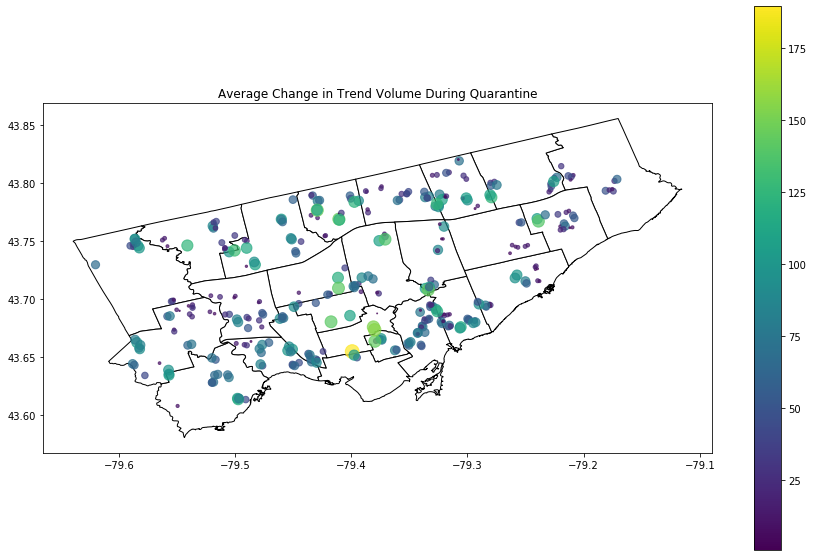

In [29]:
fig, axs = plt.subplots(figsize=(15, 10))
axs.set_aspect('equal')

gdf = gp.GeoDataFrame(changes, geometry='geometry')

toronto.plot(ax=axs, color='white', edgecolor='black')
gdf.plot(column='decrease_in_volume', ax=axs, marker='o', markersize='decrease_in_volume', 
         legend=True, alpha=0.7)
axs.set_title("Average Change in Trend Volume During Quarantine")
plt.show()

In [30]:
changes['percent_decrease'] = (changes['decrease_in_volume'] / changes['trend_volume_x']) * 100

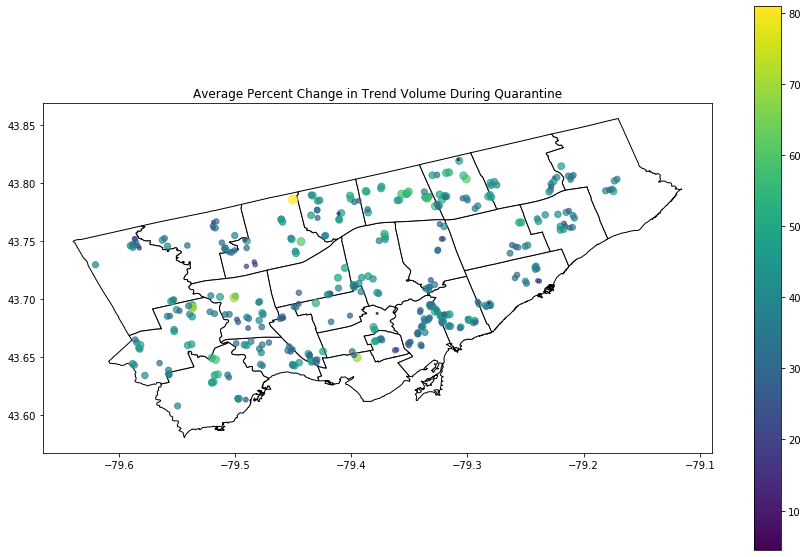

In [31]:
fig, axs = plt.subplots(figsize=(15, 10))
axs.set_aspect('equal')

gdf = gp.GeoDataFrame(changes, geometry='geometry')

toronto.plot(ax=axs, color='white', edgecolor='black')
gdf.plot(column='percent_decrease', ax=axs, marker='o', markersize='percent_decrease', 
         legend=True, alpha=0.7)
axs.set_title("Average Percent Change in Trend Volume During Quarantine")
plt.show()

### By Ward

In [32]:
wardaverages1 = modeldata[(~modeldata['quarantine']) & (~modeldata['hoardingseason'])].groupby('ward_no')['trend_volume'].mean()
wardaverages1 = pd.merge(wardaverages1.reset_index(), toronto, how='inner', left_on='ward_no', right_on='AREA_SHORT_CODE')
wardaverages1['trend_volume'] = wardaverages1['trend_volume'].map(lambda x: int(x))
gdf1 = gp.GeoDataFrame(wardaverages1, geometry='geometry')

wardaverages2 = modeldata[modeldata['quarantine']].groupby('ward_no')['trend_volume'].mean()
wardaverages2 = pd.merge(wardaverages2.reset_index(), toronto, how='inner', left_on='ward_no', right_on='AREA_SHORT_CODE')
wardaverages2['trend_volume'] = wardaverages2['trend_volume'].map(lambda x: int(x))
gdf2 = gp.GeoDataFrame(wardaverages2, geometry='geometry')

In [33]:
gdf1['coords'] = gdf1['geometry'].apply(lambda x: x.representative_point().coords[:])
gdf1['coords'] = [coords[0] for coords in gdf1['coords']]
gdf1['coords'] = [(coords[0], coords[1] - 0.005) for coords in gdf1['coords']]

gdf2['coords'] = gdf2['geometry'].apply(lambda x: x.representative_point().coords[:])
gdf2['coords'] = [coords[0] for coords in gdf2['coords']]
gdf2['coords'] = [(coords[0], coords[1] - 0.005) for coords in gdf2['coords']]

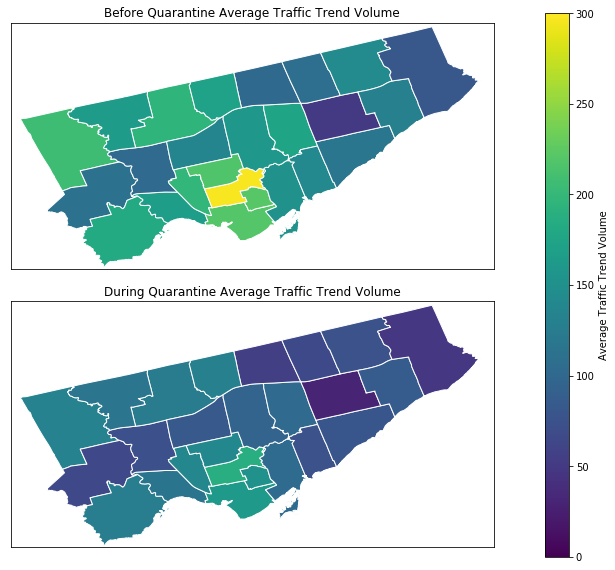

In [35]:
fig = plt.figure(figsize=(10, 10))

gs = gridspec.GridSpec(2, 2, width_ratios = [20, 1], hspace=0.05)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

gdf1.plot(column='trend_volume', ax=ax1, vmax=300, vmin=0, edgecolor='white')
ax1.set_title("Before Quarantine Average Traffic Trend Volume")
ax1.set_xlim(-79.65, -79.1)
ax1.set_ylim(43.58, 43.86)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

gdf2.plot(column='trend_volume', ax=ax2, vmax=300, vmin=0, edgecolor='white', legend=True,
         legend_kwds={'label': "Average Traffic Trend Volume", 'cax': ax3})

ax2.set_title("During Quarantine Average Traffic Trend Volume")
ax2.set_xlim(-79.65, -79.1)
ax2.set_ylim(43.58, 43.86)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.savefig('torontoheatmap.png')
plt.show()

The numbers on each ward was added manually using Photoshop.

In [36]:
changes = pd.merge(wardaverages1[['trend_volume', 'geometry', 'ward_no']], 
                   wardaverages2[['ward_no', 'trend_volume']], how='inner', on='ward_no')

changes['decrease_in_volume'] = changes['trend_volume_x'] - changes['trend_volume_y']

changes = changes[changes['decrease_in_volume'] > 0]

changes['percent_decrease'] = (changes['decrease_in_volume'] / changes['trend_volume_x']) * 100

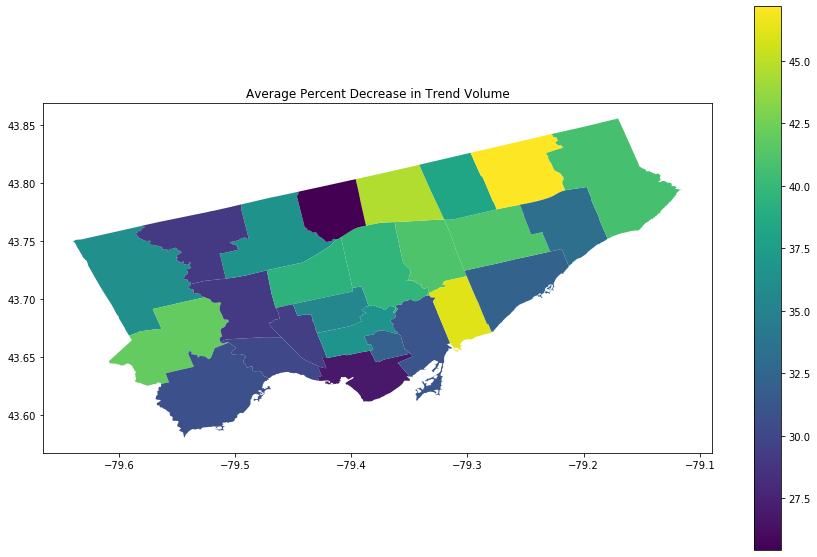

In [38]:
fig, axs = plt.subplots(figsize=(15, 10))

gdf = gp.GeoDataFrame(changes, geometry='geometry')

gdf.plot(column='percent_decrease', ax=axs, legend=True)
axs.set_title("Average Percent Decrease in Trend Volume")
plt.show()